In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# proj_path = "/content/drive/MyDrive/Development/Mach_Trans_CNN/"
# data_path = "/content/drive/MyDrive/Development/Mach_Trans_CNN/data/"

In [ ]:
# %pwd

In [ ]:
# import os
# os.chdir(proj_path)

In [ ]:
# %pwd

In [ ]:
import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout, Input
from tensorflow.keras import Model
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle
import random
import re
import tqdm
import unicodedata
import tensorflow as tf
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle
import pandas as pd

We will use the bottom-up approach, i.e. build the transformer from the bottom most layer and then walk upwards. This notebook builds each layer as a separate model so that they can be plugged into a full fledged model.

## Load Data

In [ ]:
# ds = pd.read_csv(data_path+"Hindi_Text.csv")
ds = pd.read_csv("Hindi_Text.csv")
print(f'Total number of examples = {len(ds)}')
ds.head()

Total number of examples = 127607


,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
ds['eng_len']=ds['english_sentence'].apply(lambda x:len(str(x).split(" ")))
ds['hin_len']=ds['hindi_sentence'].apply(lambda x:len(str(x).split(" ")))
ds.head()

,source,english_sentence,hindi_sentence,eng_len,hin_len
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",12,14
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,9,11
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,10,9
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,12,11
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,9,8


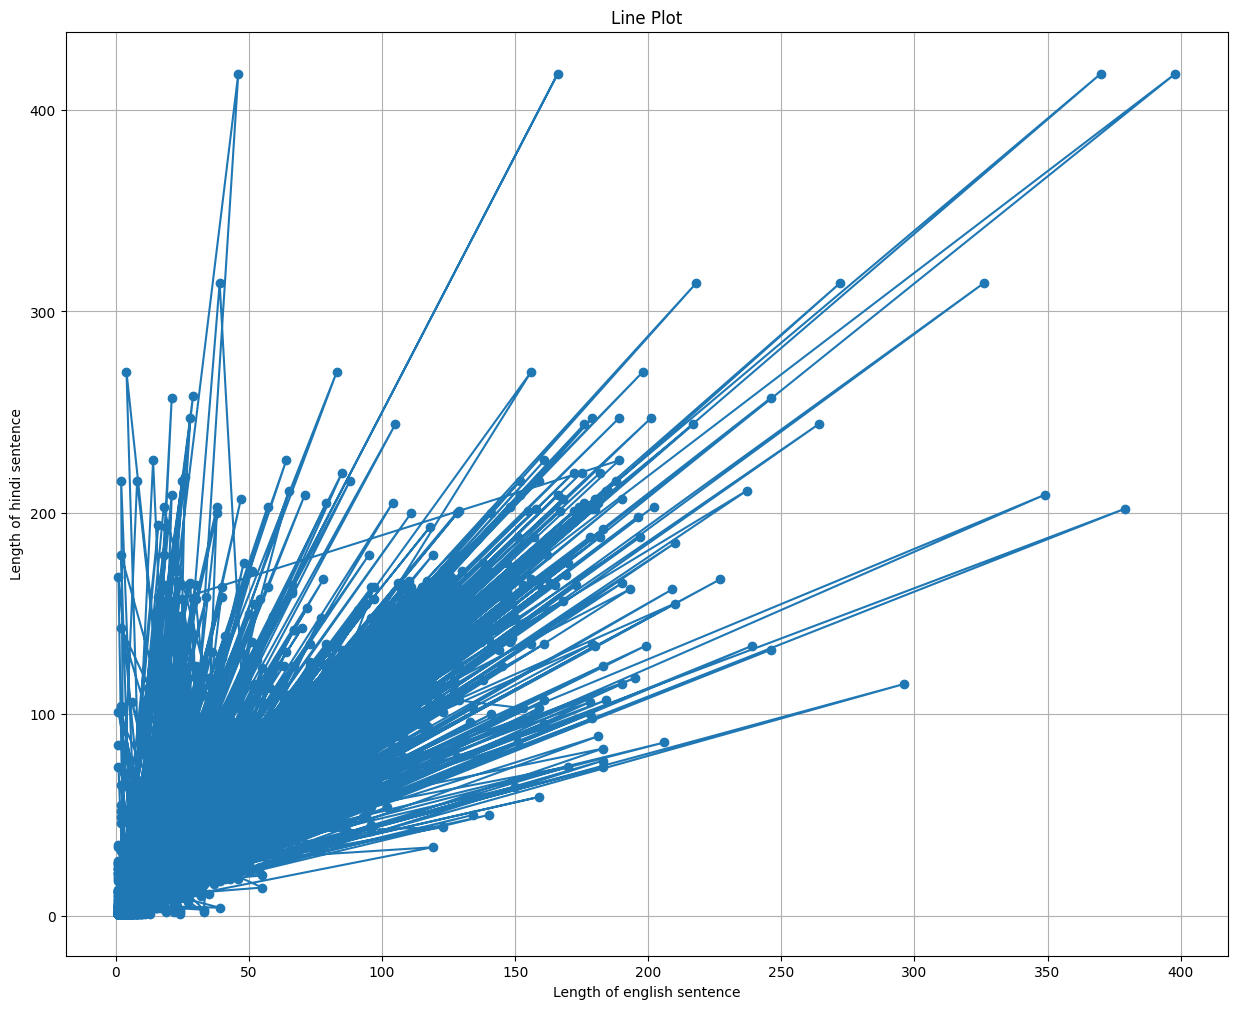

In [ ]:
plt.figure(figsize=(15, 12))
plt.plot(ds['eng_len'], ds['hin_len'], marker='o', linestyle='-')
plt.title('Line Plot')
plt.xlabel('Length of english sentence')
plt.ylabel('Length of hindi sentence')
plt.grid(True)
plt.show()

In [ ]:
ds = ds[(ds['eng_len'] < 20)]
ds = ds[(ds['hin_len'] < 20)]
print(f'Total number of examples = {len(ds)}')

Total number of examples = 83053


In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
ds['english_sentence']=ds['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in filters))
ds['hindi_sentence']=ds['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in filters))

In [ ]:
ds['english_sentence'] = ds['english_sentence'].apply(lambda x: "[start] " + x + " [end]")
ds['hindi_sentence'] = ds['hindi_sentence'].apply(lambda x: "[start] " + x + " [end]")
ds.head()

,source,english_sentence,hindi_sentence,eng_len,hin_len
0,ted,[start] politicians do not have permission to ...,[start] राजनीतिज्ञों के पास जो कार्य करना चाहि...,12,14
1,ted,[start] I'd like to tell you about one such ch...,[start] मई आपको ऐसे ही एक बच्चे के बारे में बत...,9,11
2,indic2012,[start] This percentage is even greater than t...,[start] यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,10,9
3,ted,[start] what we really mean is that they're ba...,[start] हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,12,11
4,indic2012,[start] The ending portion of these Vedas is c...,[start] इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,9,8


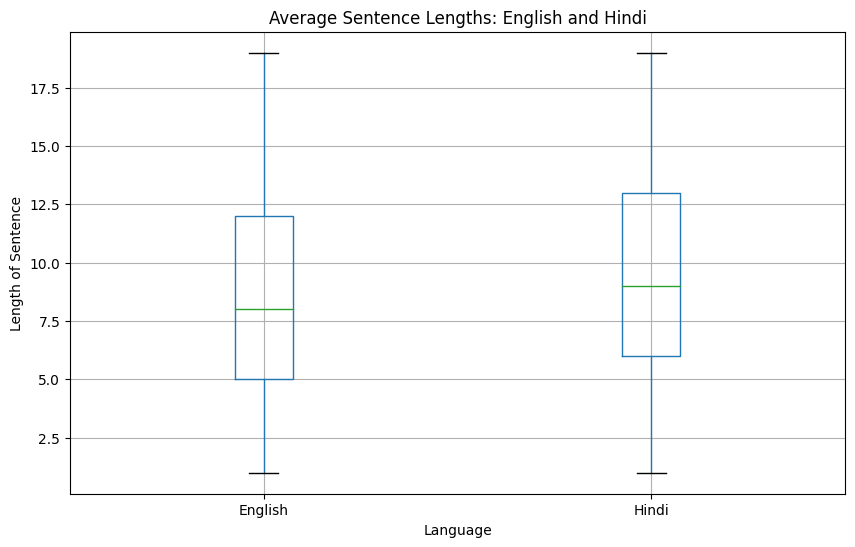

In [ ]:
# Box plot for average sentence lengths
plt.figure(figsize = (10, 6))
ds.boxplot(column = ["eng_len", "hin_len"])

# Setting labels and title
plt.title("Average Sentence Lengths: English and Hindi")
plt.xlabel("Language")
plt.ylabel("Length of Sentence")
plt.xticks([1, 2], ["English", "Hindi"])

plt.grid(True)
plt.show()

## Data Preprocessing

In [ ]:
# ds = ds.sample(frac=0.1).reset_index(drop=True)
# len(ds)
def normalize(eng, hin):
    """Normalize a line of text and split into two at the tab character"""
    line = str(eng.strip().lower()) + "\t" + str(hin.strip())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, hind = line.split('\t')
    return eng, hin

text_pairs = []
for index in ds.index:
    text_pairs.append(normalize(ds['english_sentence'][index], ds['hindi_sentence'][index]))
print(len(text_pairs))

83053


In [ ]:
text_pairs[:6]

[(' [ start ] politicians do not have permission to do what needs to be done  [ end ]',
  '[start] राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है  [end]'),
 (" [ start ] i'd like to tell you about one such child  [ end ]",
  '[start] मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी [end]'),
 (' [ start ] this percentage is even greater than the percentage in india  [ end ]',
  '[start] यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है। [end]'),
 (" [ start ] what we really mean is that they're bad at not paying attention  [ end ]",
  '[start] हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते [end]'),
 (' [ start ] the ending portion of these vedas is called upanishad  [ end ]',
  '[start] इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है। [end]'),
 (' [ start ] in this lies the circumstances of people before you  [ end ]',
  '[start] इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं। [end]')]

## Parameters

In [ ]:
n_sentences = None
batch_size=32

if n_sentences is None:
    text_pairs = text_pairs[:]
else:
    text_pairs = text_pairs[:n_sentences]

In [ ]:
# Create train, val and testing datasets
val_split = 0.15

# shuffle
# ds = ds.sample(frac = 1)
len_text_pairs = len(text_pairs)
n_val_index = int(val_split * len_text_pairs)
n_train_index = len_text_pairs - 2 * n_val_index

train_tp = text_pairs[:n_train_index]
test_tp = text_pairs[n_train_index:n_train_index + n_val_index]
val_tp = text_pairs[n_train_index + n_val_index:]
print(f"Train: {len(train_tp)}")
print(f"Validation: {len(val_tp)}")
print(f"Test: {len(test_tp)}")

Train: 58139
Validation: 12457
Test: 12457


In [ ]:
train_tp[:3]

[(' [ start ] politicians do not have permission to do what needs to be done  [ end ]',
  '[start] राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है  [end]'),
 (" [ start ] i'd like to tell you about one such child  [ end ]",
  '[start] मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी [end]'),
 (' [ start ] this percentage is even greater than the percentage in india  [ end ]',
  '[start] यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है। [end]')]

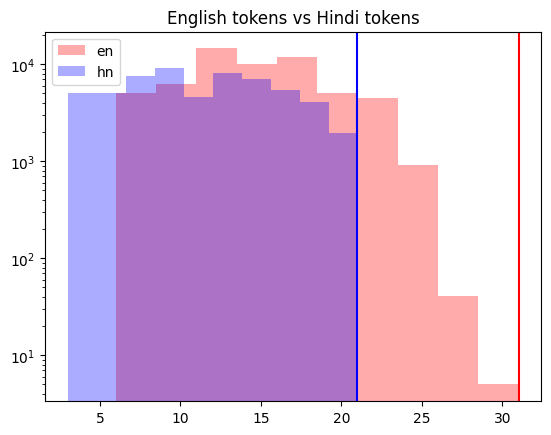

In [ ]:
# histogram of sentence length in tokens
en_lengths = [len(e.split()) for e, h in train_tp]
hn_lengths = [len(h.split()) for e, h in train_tp]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(hn_lengths, label="hn", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(hn_lengths), max(hn_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("English tokens vs Hindi tokens")
plt.show()

In [ ]:
 # count tokens
eng_tokens, hin_tokens = set(), set()
eng_maxlen, hin_maxlen = 0, 0
for eng, hin in text_pairs:
    eng_tok, hin_tok = eng.split(), hin.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    hin_maxlen = max(hin_maxlen, len(hin_tok))
    eng_tokens.update(eng_tok)
    hin_tokens.update(hin_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total Hindi tokens: {len(hin_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max Hindi length: {hin_maxlen}")
print(f"{len(text_pairs)} total pairs")
vocab_size_en = len(eng_tokens)
vocab_size_hn = len(hin_tokens)

Total English tokens: 41054
Total Hindi tokens: 42631
Max English length: 31
Max Hindi length: 21
83053 total pairs


In [ ]:
english_sentences = ' '.join(
    sentence.split('[ start ]')[1].split(' [ end ]')[0].strip() for sentence, _ in train_tp)

In [ ]:
hindi_sentences = ' '.join(
    sentence.split('[start]')[1].split('[end]')[0].strip() for _, sentence in train_tp)

In [ ]:
hindi_sentences_stripped = ' '.join(hindi_sentences.split())

### Wordcloud for English and Hindi Data

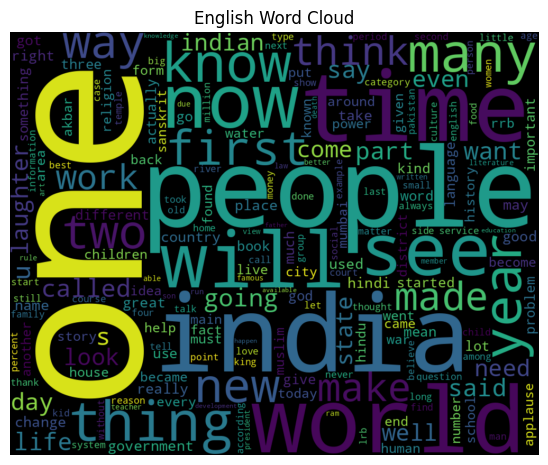

In [ ]:
from wordcloud import WordCloud

# Create word cloud for English
english_wordcloud = WordCloud(width=1000, height=800, background_color='black').generate(english_sentences)

# Plot English word cloud
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(english_wordcloud, interpolation='bilinear')
plt.title('English Word Cloud')
plt.axis('off')

plt.show()

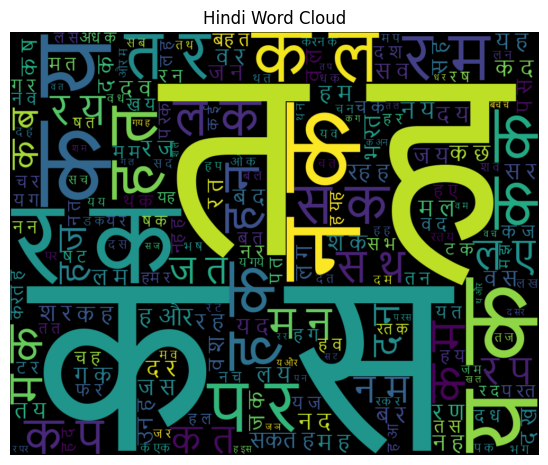

In [ ]:
# Create word cloud for Hindi
hindi_wordcloud = WordCloud(width=1000, height=800, background_color='black',
                            font_path='Nirmala.ttf').generate(hindi_sentences)

# Plot English word cloud
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(hindi_wordcloud, interpolation='bilinear')
plt.title('Hindi Word Cloud')
plt.axis('off')

plt.show()

In [ ]:
from collections import Counter

# Tokenizing and counting words for English
english_words = english_sentences.split()
english_word_counts = Counter(english_words)
english_top_25 = english_word_counts.most_common(25)

# Tokenizing and counting words for Hindi
# Assuming words in Hindi sentences are separated by spaces
hindi_words = hindi_sentences.split()
hindi_word_counts = Counter(hindi_words)
hindi_top_25 = hindi_word_counts.most_common(25)

# Extracting words and counts for plotting
english_words, english_counts = zip(*english_top_25)
hindi_words, hindi_counts = zip(*hindi_top_25)

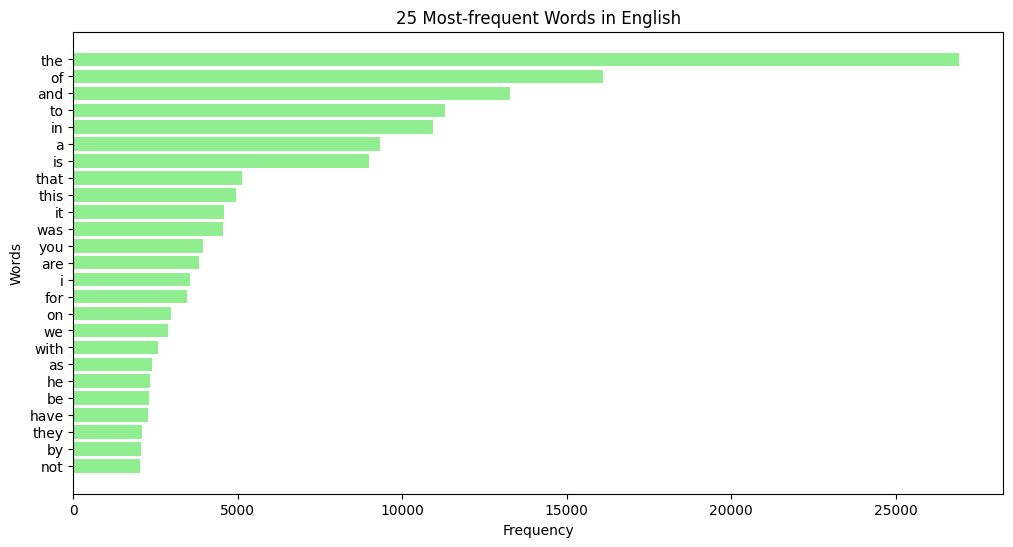

In [ ]:
# Plotting top 25 frequent words for English
plt.figure(figsize=(12, 6))
plt.barh(english_words, english_counts, color='lightgreen')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('25 Most-frequent Words in English')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent words at the top
plt.show()

In [ ]:
font_path = "/content/Nirmala.ttf"

In [ ]:
import matplotlib.font_manager as pltfm
custom_font = pltfm.FontProperties(fname = font_path)

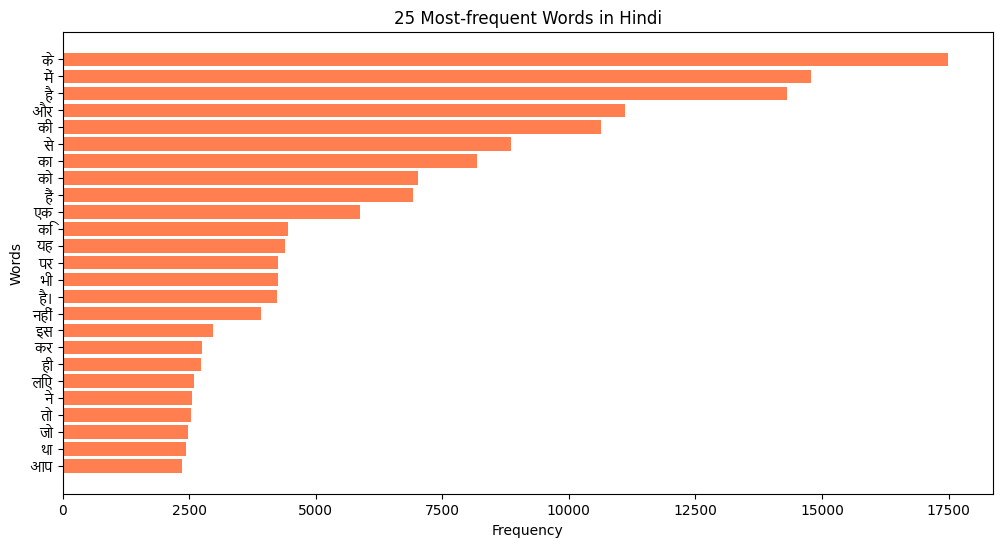

In [ ]:
# Plotting top 25 frequent words for Hindi
plt.figure(figsize=(12, 6))
plt.barh(hindi_words, hindi_counts, color='coral')

plt.yticks(fontproperties = custom_font)

plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('25 Most-frequent Words in Hindi')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent words at the top
plt.show()

### Initialize Vectorizers

In [ ]:
seq_length = 15

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
hin_vectorizer = TextVectorization(
    max_tokens=vocab_size_hn,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)


#### Prepare training dataset

In [ ]:
train_eng_texts = [pairs[0] for pairs in train_tp]
train_hin_texts = [pairs[1] for pairs in train_tp]

eng_vectorizer.adapt(train_eng_texts)
hin_vectorizer.adapt(train_hin_texts)

# set up Dataset object
def format_dataset(eng, hin):
    eng = eng_vectorizer(eng)
    hin = hin_vectorizer(hin)
    source = (eng, hin[:, :-1])
    target = hin[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, hin_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(hin_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_tp)
val_ds = make_dataset(val_tp)

In [ ]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs[0].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs[0][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs[1].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs[1][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 15)
inputs["encoder_inputs"][0]: [    3     5     2   611 14521 10893 14521   417     8  5091     7  2480
     3     4     2]
inputs["decoder_inputs"].shape: (64, 15)
inputs["decoder_inputs"][0]: [   2 2211  470  605 2186   11 1926 1133  470  605 2186   11 1305 3228
  470]
targets.shape: (64, 15)
targets[0]: [2211  470  605 2186   11 1926 1133  470  605 2186   11 1305 3228  470
  605]


In [ ]:
eng_lookup = list(eng_vectorizer.get_vocabulary())
hin_lookup = list(hin_vectorizer.get_vocabulary())
eng_sen, hin_sen, hin_source = "", "",""
print(inputs[1].shape)
for index in inputs[0][0]:
  eng_sen += eng_lookup[index.numpy()] + " "
for index in targets[0]:
  hin_source += hin_lookup[index.numpy()] + " "
print(f"source: {eng_sen}")
print(f"hin source: {hin_source}")

(64, 15)
source: [ start ] result female's convinience female's problems and enjoyment of females [ end ] 
hin source: मूल्यांकन · महिला Receiver को सहूलियत ☻☻☻☻ · महिला Receiver को परेशानी ☻ · महिला 


In [ ]:
# Find the vocab size - how many distinct tokens exist
print(f"Total English tokens = {vocab_size_en}.")
print(f"Total Hindi tokens = {vocab_size_hn}.")

Total English tokens = 41054.
Total Hindi tokens = 42631.


In [ ]:
for (eng, hin), hn_labels in train_ds.take(1):
  break
print(eng.shape)
print(hin.shape)
print(hn_labels.shape)

print(hin[0][:10])
print(hn_labels[0][:10])

(64, 15)
(64, 15)
(64, 15)
tf.Tensor([   2  916   90 2830   59 1815  296  964   18    3], shape=(10,), dtype=int64)
tf.Tensor([ 916   90 2830   59 1815  296  964   18    3    0], shape=(10,), dtype=int64)


#### Positional Embedding Layer



In [ ]:
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

pos_matrix = positional_encoding(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.84147096  0.00999983  0.5403023   0.99995   ]
 [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
 [ 0.14112     0.0299955  -0.9899925   0.99955004]], shape=(4, 4), dtype=float32)


In [ ]:
# Positional Embedding
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
eng_pos = PositionalEmbedding(vocab_size_en, 512)
hin_pos = PositionalEmbedding(vocab_size_hn, 512)
print(eng_pos(eng).shape)
print(hin_pos(hin).shape)

(64, 15, 512)
(64, 15, 512)


### Defining Model components

In [ ]:
# Self Attention Layer

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
enc_output = eng_pos(eng)
print(enc_output.shape)
print(sample_gsa(enc_output).shape)

(64, 15, 512)
(64, 15, 512)


In [ ]:
## Cross Attention Layer

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
emb_output_hin = hin_pos(hin)
print(emb_output_eng.shape)
print(emb_output_hin.shape)
print(sample_ca(emb_output_eng, emb_output_hin).shape)

(64, 15, 512)
(64, 15, 512)
(64, 15, 512)


In [ ]:
# Casual Self Attention

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
print(emb_output_eng.shape)
print(sample_csa(emb_output_eng).shape)

(64, 15, 512)
(64, 15, 512)


In [ ]:
# Feedforward Layer

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [ ]:
sample_ffn = FeedForward(512, 2048)
print(sample_ffn(emb_output_eng).shape)

(64, 15, 512)


#### Encoder

In [ ]:
# Encoder

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(emb_output_eng.shape)
print(sample_encoder_layer(emb_output_eng).shape)

(64, 15, 512)
(64, 15, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Shape `(batch_size, seq_len, d_model)`

In [ ]:
# Initialize the encoder
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_en)
sample_encoder_output = sample_encoder(eng, training=False)
print(eng.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 15)
(64, 15, 512)


#### Decoder

In [ ]:
# Decoder

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_hn)
output = sample_decoder(x=hin,context=emb_output_eng)
# Print the shapes.
print(hin.shape)
print(emb_output_hin.shape)
print(output.shape)

(64, 15)
(64, 15, 512)
(64, 15, 512)


In [ ]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 15, 15])

#### Transformer Model

In [ ]:
# Transformer

class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Training Utilities

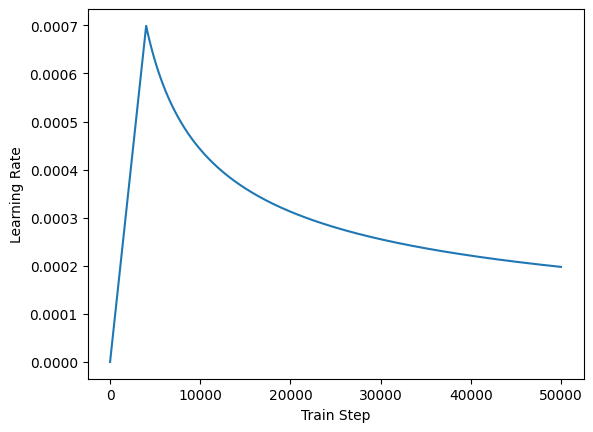

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps
    }
    return config

key_dim = 512
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = pred==label
  mask = label !=0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


## Final Model

In [ ]:
# Parameters

n_sentences = None
num_layers = 4
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_en,
    target_vocab_size=vocab_size_hn,
    dropout_rate=dropout_rate)
lr = CustomSchedule(512)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])


### Model Training

Epoch 1/12
909/909 [==============================] - 415s 420ms/step - loss: 7.5349 - masked_accuracy: 0.1262 - val_loss: 6.1292 - val_masked_accuracy: 0.2000
Epoch 2/12
909/909 [==============================] - 380s 418ms/step - loss: 5.7001 - masked_accuracy: 0.2272 - val_loss: 5.4359 - val_masked_accuracy: 0.2602
Epoch 3/12
909/909 [==============================] - 381s 419ms/step - loss: 5.0113 - masked_accuracy: 0.2776 - val_loss: 5.0528 - val_masked_accuracy: 0.2909
Epoch 4/12
909/909 [==============================] - 381s 419ms/step - loss: 4.4731 - masked_accuracy: 0.3166 - val_loss: 4.8593 - val_masked_accuracy: 0.3118
Epoch 5/12
909/909 [==============================] - 391s 430ms/step - loss: 3.9849 - masked_accuracy: 0.3566 - val_loss: 4.6459 - val_masked_accuracy: 0.3315
Epoch 6/12
909/909 [==============================] - 381s 419ms/step - loss: 3.3797 - masked_accuracy: 0.4203 - val_loss: 4.4834 - val_masked_accuracy: 0.3594
Epoch 7/12
909/909 [====================

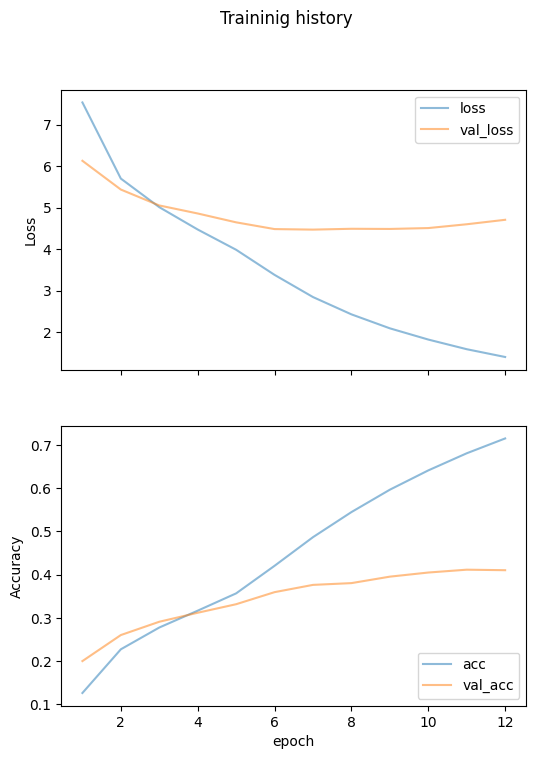

In [ ]:
# epochs = 10
epochs = 12
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

### Final Translations

In [ ]:
# training parameters used
seq_len = 20
def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(hin_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = hin_vectorizer([" ".join(output_sentence)])
        dec_tokens = vector[:, :-1]
        pred = model([enc_tokens, dec_tokens])
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 5
for n in range(test_count):
    english_sentence, Hindi_sentence = random.choice(val_tp)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {Hindi_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
 [ start ] are they cattle ”  [ end ]
== [start] क्या वे मवेशी हैं  [end]
-> [start] ये हैं ' इनकी संख्या [end]

Test 1:
 [ start ] because they didn't start until 1964  [ end ]
== [start] क्योंकि सन १९६४ तक [end]
-> [start] क्योंकि वे 1964 नहीं थे [end]

Test 2:
 [ start ] or maybe turning your digital senses totally off  [ end ]
== [start] या अपनी डिजिटल भावनाओं को बंद ही कर दो [end]
-> [start] या आप अपने डिजिटल तरीके से संपर्क करते हैं [end]

Test 3:
 [ start ] god remain in touch with these messengers in different look  [ end ]
== [start] ईश्वर इन दूतों से विभिन्न रूपों से समपर्क रखते थे। [end]
-> [start] ईश्वर इन दूतों से विभिन्न रूपों से समपर्क रखते थे। [end]

Test 4:
 [ start ] god remain in touch with these messengers in different look  [ end ]
== [start] ईश्वर इन दूतों से विभिन्न रूपों से समपर्क रखते थे। [end]
-> [start] ईश्वर इन दूतों से विभिन्न रूपों से समपर्क रखते थे। [end]

